# **Case Datarisk - Score de Crédito**

TODO:
- matriz de migração
- criar variáveis de histórico
  - modere usando o contrato
- Técnicas de seleção de variável:
  - mrmr, boruta
  - fazer um modelo inicial, ver quais variáveis são as mais importantes
- optuna para otimizar hiperparâmetros
- Testar modelos:
  - Testar regressão logística, binarização
  - Focar nas técnicas de boosting

## **Importa as bibliotecas e Carrega os Dados**

In [ ]:
from utils.load_df import load_df
from utils.convert_to_datetime import convert_to_datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

import requests
from pathlib import Path

github_url = 'https://github.com/datarisk-io/datarisk-case-ds/raw/master/data'

In [16]:
import pyarrow.parquet as pq

def download_file(url: str, local_path: str, chunk_size: int = 1024):
    """Baixa o arquivo da URL de forma segura, em chunks."""
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Levanta erro se status != 200
    with open(local_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=chunk_size):
            f.write(chunk)

def load_df_from_url(dir_path: str, url: str) -> pd.DataFrame | None:
    dir_path = Path(dir_path)
    dir_path.mkdir(parents=True, exist_ok=True)

    file_name = url.split('/')[-1]
    local_path = dir_path / file_name

    # Baixar apenas se não existir
    if not local_path.exists():
        try:
            download_file(url, local_path)
        except Exception as e:
            print(f"Erro ao baixar o arquivo de {url}: {e}")
            return None

    return load_df(local_path)

# Carregar os DataFrames
df_cadastral = load_df_from_url("./data", f"{github_url}/base_cadastral.parquet")
df_emprestimos = load_df_from_url("./data", f"{github_url}/historico_emprestimos.parquet")
df_submissao = load_df_from_url("./data", f"{github_url}/base_submissao.parquet")
df_parcelas = load_df_from_url("./data", f"{github_url}/historico_parcelas.parquet")
dicionario = load_df_from_url("./data", f"{github_url}/dicionario_dados.csv")


## **Análise Preliminar e Qualidade dos Dados**



In [5]:
display(dicionario)

,base,coluna,descricao
0,base_cadastral,id_cliente,Identificador único do cliente
1,base_cadastral,sexo,Sexo do cliente (M ou F)
2,base_cadastral,data_nascimento,Data de nascimento do cliente
3,base_cadastral,qtd_filhos,Quantidade de filhos declarados
4,base_cadastral,qtd_membros_familia,Quantidade total de membros da família
...,...,...,...
64,historico_parcelas,numero_parcela,Número sequencial da parcela dentro do contrato
65,historico_parcelas,data_prevista_pagamento,Data inicialmente prevista para o pagamento da...
66,historico_parcelas,data_real_pagamento,Data real em que o pagamento foi efetuado
67,historico_parcelas,valor_previsto_parcela,Valor original previsto da parcela


In [8]:
def display_missings(df):
  missing_values = df.isna().sum()

  # Filtra apenas as colunas com nulos
  missing_values_filtered = missing_values[missing_values > 0]

  # Calcula a porcentagem
  total_rows = len(df)
  percentage_missing = ((missing_values_filtered / total_rows) * 100).round(1)

  # Cria um novo DataFrame para exibir as informações
  missing_info = pd.DataFrame({
      'Contagem de Nulos': missing_values_filtered,
      'Porcentagem de Nulos (%)': percentage_missing
  })

  missing_info_sorted = missing_info.sort_values(by='Porcentagem de Nulos (%)', ascending=False)

  display(missing_info_sorted)

In [9]:
def df_overview(df, name):
  '''
  Visão geral da base de dados
  '''
  print('='*12 + f" Base {name} " + '='*12)
  print("\nDimensão da base:", df.shape)
  print("Amostras duplicadas:", df.duplicated().sum())

  print("\n" + "-"*40)
  print("\nInfo da base:")
  df.info()

  print("\n" + "-"*40)
  print("\nValores Missing:")
  display_missings(df)

  print("\n" + "-"*40)
  print("\n Estatísticas descritivas:")
  # Excluir colunas de ID antes de calcular estatísticas descritivas
  cols_to_exclude = ['id_contrato', 'id_cliente']
  df_for_describe = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')
  display(df_for_describe.describe().transpose())

  print("\n" + "-"*40)
  print("\n Primeiras linhas:")
  display(df.head(3))

In [10]:
df_overview(df_cadastral, "Cadastral")

============ Base Cadastral ============

Dimensão da base: (40000, 16)
Amostras duplicadas: 0

----------------------------------------

Info da base:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_cliente                  40000 non-null  int64  
 1   sexo                        40000 non-null  object 
 2   data_nascimento             40000 non-null  object 
 3   qtd_filhos                  40000 non-null  int64  
 4   qtd_membros_familia         40000 non-null  float64
 5   renda_anual                 40000 non-null  float64
 6   tipo_renda                  40000 non-null  object 
 7   ocupacao                    27324 non-null  object 
 8   tipo_organizacao            40000 non-null  object 
 9   nivel_educacao              40000 non-null  object 
 10  estado_civil                40000 non-null  object

,Contagem de Nulos,Porcentagem de Nulos (%)
ocupacao,12676,31.7



----------------------------------------

 Estatísticas descritivas:


,count,mean,std,min,25%,50%,75%,max
qtd_filhos,40000.0,0.413225,0.718006,0.0,0.0,0.0,1.0,14.0
qtd_membros_familia,40000.0,2.153175,0.903622,1.0,2.0,2.0,3.0,15.0
renda_anual,40000.0,172853.865017,602510.230147,26100.0,112500.0,148500.0,202500.0,117000000.0
nota_regiao_cliente,40000.0,2.051475,0.509295,1.0,2.0,2.0,2.0,3.0
nota_regiao_cliente_cidade,40000.0,2.029375,0.503158,1.0,2.0,2.0,2.0,3.0



----------------------------------------

 Primeiras linhas:


,id_cliente,sexo,data_nascimento,qtd_filhos,qtd_membros_familia,renda_anual,tipo_renda,ocupacao,tipo_organizacao,nivel_educacao,estado_civil,tipo_moradia,possui_carro,possui_imovel,nota_regiao_cliente,nota_regiao_cliente_cidade
0,100023,F,1994-01-30,1,2.0,90000.0,State servant,Core staff,Kindergarten,Higher education,Single / not married,House / apartment,N,Y,2,2
1,100031,F,1973-11-13,0,1.0,112500.0,Working,Cooking staff,Business Entity Type 3,Secondary / secondary special,Widow,House / apartment,N,Y,3,2
2,100056,M,1975-02-19,0,2.0,360000.0,Working,Laborers,Transport: type 2,Secondary / secondary special,Married,House / apartment,Y,Y,2,2


In [35]:
df_overview(df_emprestimos, "Histórico de Empréstimos")

============ Base Histórico de Empréstimos ============

Dimensão da base: (186890, 37)
Amostras duplicadas: 0

----------------------------------------

Info da base:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186890 entries, 0 to 186889
Data columns (total 37 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id_contrato                       186890 non-null  int64  
 1   id_cliente                        186890 non-null  int64  
 2   tipo_contrato                     186890 non-null  object 
 3   status_contrato                   186890 non-null  object 
 4   data_decisao                      186890 non-null  object 
 5   data_liberacao                    7100 non-null    object 
 6   data_primeiro_vencimento          107145 non-null  object 
 7   data_ultimo_vencimento_original   101143 non-null  object 
 8   data_ultimo_vencimento            87778 non-null   object 
 9   data_encerra

,Contagem de Nulos,Porcentagem de Nulos (%)
taxa_juros_padrao,186262,99.7
taxa_juros_promocional,186262,99.7
data_liberacao,179790,96.2
data_encerramento,100803,53.9
valor_entrada,100168,53.6
percentual_entrada,100168,53.6
data_ultimo_vencimento,99112,53.0
acompanhantes_cliente,92104,49.3
data_ultimo_vencimento_original,85747,45.9
data_primeiro_vencimento,79745,42.7



----------------------------------------

 Estatísticas descritivas:


,count,mean,std,min,25%,50%,75%,max
valor_solicitado,186890.0,174010.337803,290351.501797,0.000000,18135.000000,70758.000000,180000.000000,3.825000e+06
valor_credito,186890.0,194709.440489,316121.766016,0.000000,23607.000000,80091.000000,215640.000000,3.749054e+06
valor_bem,143453.0,226721.309642,312864.937635,0.000000,50850.000000,112036.500000,233910.000000,3.825000e+06
valor_parcela,145126.0,15904.691449,14777.235207,0.000000,6312.735000,11250.000000,20559.757500,4.179276e+05
valor_entrada,86722.0,6734.048557,20423.779104,0.000000,0.000000,1575.000000,7758.000000,1.344510e+06
percentual_entrada,86722.0,0.079906,0.108498,0.000000,0.000000,0.050340,0.108912,9.897399e-01
qtd_parcelas_planejadas,145127.0,16.015235,14.527090,0.000000,6.000000,12.000000,24.000000,8.400000e+01
taxa_juros_padrao,628.0,0.183593,0.074714,0.059121,0.160713,0.189122,0.193330,7.974470e-01
taxa_juros_promocional,628.0,0.774674,0.102681,0.424419,0.715645,0.835095,0.852537,1.000000e+00
area_venda,186890.0,304.101889,1600.375985,-1.000000,-1.000000,3.000000,84.000000,1.200000e+05



----------------------------------------

 Primeiras linhas:


,id_contrato,id_cliente,tipo_contrato,status_contrato,data_decisao,data_liberacao,data_primeiro_vencimento,data_ultimo_vencimento_original,data_ultimo_vencimento,data_encerramento,...,setor_vendedor,canal_venda,area_venda,dia_semana_solicitacao,hora_solicitacao,flag_ultima_solicitacao_contrato,flag_ultima_solicitacao_dia,motivo_recusa,acompanhantes_cliente,flag_seguro_contratado
0,2802425,108129,Cash loans,Approved,2024-08-29,None,2024-09-28,2027-08-14,None,None,...,XNA,Contact center,-1,THURSDAY,11,Y,1,XAP,Unaccompanied,1.0
1,2330894,258628,Cash loans,Approved,2022-10-11,None,2022-11-10,2024-09-30,2024-08-01,2024-08-04,...,XNA,Credit and cash offices,-1,TUESDAY,15,Y,1,XAP,Unaccompanied,1.0
2,1182516,267782,Cash loans,Approved,2023-04-08,None,2023-05-08,2025-09-24,None,None,...,XNA,Credit and cash offices,-1,SATURDAY,4,Y,1,XAP,None,1.0


In [36]:
df_overview(df_parcelas, "Histórico de Parcelas")

============ Base Histórico de Parcelas ============

Dimensão da base: (1390978, 8)
Amostras duplicadas: 0

----------------------------------------

Info da base:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1390978 entries, 0 to 1390977
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id_contrato              1390978 non-null  int64  
 1   id_cliente               1390978 non-null  int64  
 2   versao_parcela           1390978 non-null  float64
 3   numero_parcela           1390978 non-null  int64  
 4   data_prevista_pagamento  1390978 non-null  object 
 5   data_real_pagamento      1390639 non-null  object 
 6   valor_previsto_parcela   1390978 non-null  float64
 7   valor_pago_parcela       1390639 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 84.9+ MB

----------------------------------------

Valores Missing:


,Contagem de Nulos,Porcentagem de Nulos (%)
data_real_pagamento,339,0.0
valor_pago_parcela,339,0.0



----------------------------------------

 Estatísticas descritivas:


,count,mean,std,min,25%,50%,75%,max
versao_parcela,1390978.0,0.927373,1.059711,0.0,1.000,1.0000,1.000,52.00
numero_parcela,1390978.0,14.920966,20.901487,1.0,4.000,8.0000,15.000,194.00
valor_previsto_parcela,1390978.0,18145.870182,52183.436008,0.0,4677.165,9300.5775,17902.575,2784334.14
valor_pago_parcela,1390639.0,18353.372255,56500.724895,0.0,4106.925,8980.2450,17246.925,2784334.14



----------------------------------------

 Primeiras linhas:


,id_contrato,id_cliente,versao_parcela,numero_parcela,data_prevista_pagamento,data_real_pagamento,valor_previsto_parcela,valor_pago_parcela
0,1594684,100193,0.0,56,2021-12-21,2021-12-21,301.86,301.86
1,1995642,134723,1.0,38,2021-08-09,2021-08-04,12949.20,12949.20
2,1720935,176364,1.0,9,2024-03-06,2024-03-04,61192.53,61192.53


In [37]:
df_overview(df_submissao, "Submissão")

============ Base Submissão ============

Dimensão da base: (40000, 8)
Amostras duplicadas: 0

----------------------------------------

Info da base:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_cliente              40000 non-null  int64  
 1   data_solicitacao        40000 non-null  object 
 2   dia_semana_solicitacao  40000 non-null  object 
 3   hora_solicitacao        40000 non-null  int64  
 4   tipo_contrato           40000 non-null  object 
 5   valor_credito           40000 non-null  float64
 6   valor_bem               39976 non-null  float64
 7   valor_parcela           39996 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 2.4+ MB

----------------------------------------

Valores Missing:


,Contagem de Nulos,Porcentagem de Nulos (%)
valor_bem,24,0.1
valor_parcela,4,0.0



----------------------------------------

 Estatísticas descritivas:


,count,mean,std,min,25%,50%,75%,max
hora_solicitacao,40000.0,12.028850,3.268652,0.0,10.0,12.0,14.000,23.0
valor_credito,40000.0,586259.669813,395313.882289,45000.0,270000.0,502497.0,791861.625,4050000.0
valor_bem,39976.0,526968.196205,363020.874950,40500.0,238500.0,450000.0,675000.000,4050000.0
valor_parcela,39996.0,27376.027003,14750.171247,2295.0,16681.5,25060.5,34781.625,225000.0



----------------------------------------

 Primeiras linhas:


,id_cliente,data_solicitacao,dia_semana_solicitacao,hora_solicitacao,tipo_contrato,valor_credito,valor_bem,valor_parcela
0,100023,2025-02-24,MONDAY,12,Cash loans,544491.0,454500.0,17563.5
1,100031,2025-02-17,MONDAY,9,Cash loans,979992.0,702000.0,27076.5
2,100056,2025-02-20,THURSDAY,10,Cash loans,1506816.0,1350000.0,49927.5


### **Verificação de chaves das bases**

In [38]:
def count_ids(df, name):
  ids = set(df['id_cliente'])
  print(f"IDs únicos na base {name}: {len(ids)}")

  return ids

ids_emprestimos = count_ids(df_emprestimos, 'empréstimos')
ids_parcelas = count_ids(df_parcelas, 'parcelas')
ids_cadastral = count_ids(df_cadastral, 'cadastral')
ids_submissao = count_ids(df_submissao, 'submissão')

IDs únicos na base empréstimos: 37952
IDs únicos na base parcelas: 37739
IDs únicos na base cadastral: 40000
IDs únicos na base submissão: 40000


In [39]:
print(f"Todos os IDs de Empréstimos estão na Cadastral? {ids_emprestimos.issubset(ids_cadastral)}")
print(f"Todos os IDs de Parcelas estão na Cadastral? {ids_parcelas.issubset(ids_cadastral)}")
print(f"Todos os IDs de Empréstimos estão na Cadastral? {ids_submissao.issubset(ids_cadastral)}")

Todos os IDs de Empréstimos estão na Cadastral? True
Todos os IDs de Parcelas estão na Cadastral? True
Todos os IDs de Empréstimos estão na Cadastral? True


## **Converter Datas**

In [ ]:
# listar as colunas que precisam de conversão em cada DataFrame
colunas_data_emprestimos = [
    'data_decisao',
    'data_liberacao',
    'data_primeiro_vencimento',
    'data_ultimo_vencimento_original',
    'data_ultimo_vencimento',
    'data_encerramento'
]

colunas_data_parcelas = [
    'data_prevista_pagamento',
    'data_real_pagamento'
]

colunas_data_cadastral = [
    'data_nascimento'
]

df_parcelas = convert_to_datetime(df_parcelas, colunas_data_parcelas)
df_emprestimos = convert_to_datetime(df_emprestimos, colunas_data_emprestimos)
df_cadastral = convert_to_datetime(df_cadastral, colunas_data_cadastral)


--- Verificando tipos de dados ANTES da conversão ---
data_prevista_pagamento    datetime64[ns]
data_real_pagamento        datetime64[ns]
dtype: object

--- Verificando tipos de dados DEPOIS da conversão ---
data_prevista_pagamento    datetime64[ns]
data_real_pagamento        datetime64[ns]
dtype: object

--- Verificando tipos de dados ANTES da conversão ---
data_decisao                       datetime64[ns]
data_liberacao                     datetime64[ns]
data_primeiro_vencimento           datetime64[ns]
data_ultimo_vencimento_original    datetime64[ns]
data_ultimo_vencimento             datetime64[ns]
data_encerramento                  datetime64[ns]
dtype: object

--- Verificando tipos de dados DEPOIS da conversão ---
data_decisao                       datetime64[ns]
data_liberacao                     datetime64[ns]
data_primeiro_vencimento           datetime64[ns]
data_ultimo_vencimento_original    datetime64[ns]
data_ultimo_vencimento             datetime64[ns]
data_encerramento 

## **Análise Exploratória**



In [42]:
df_emprestimos['motivo_recusa'].value_counts()

motivo_recusa
XAP       151948
HC         19292
LIMIT       6247
SCO         4222
CLIENT      2833
SCOFR       1332
XNA          522
VERIF        406
SYSTEM        88
Name: count, dtype: int64

In [43]:
df_emprestimos['status_contrato'].value_counts()

status_contrato
Approved        116182
Canceled         35767
Refused          32108
Unused offer      2833
Name: count, dtype: int64

Vamos analisar a distribuição de contratos por cliente.

Vemos que 2048 clientes (5%) ainda não assinaram um contrato.

In [44]:
# Contar o número de contratos por cliente na base de empréstimos
contratos_por_cliente_emprestimos = df_emprestimos['id_cliente'].value_counts()

# Criar um DataFrame com todos os IDs de cliente da base cadastral
all_clientes = pd.DataFrame({'id_cliente': df_cadastral['id_cliente'].unique()})

# Mesclar com a contagem de contratos, preenchendo NaN com 0 para clientes sem contratos
contratos_por_cliente = all_clientes.merge(
    contratos_por_cliente_emprestimos.rename('num_contratos'),
    left_on='id_cliente',
    right_index=True,
    how='left'
)

In [45]:
clientes_sem_contrato = contratos_por_cliente['num_contratos'].isna().sum()
print(f"Número de clientes sem contrato: {clientes_sem_contrato}")

Número de clientes sem contrato: 2048


In [46]:
contratos_por_cliente = contratos_por_cliente.fillna(0)

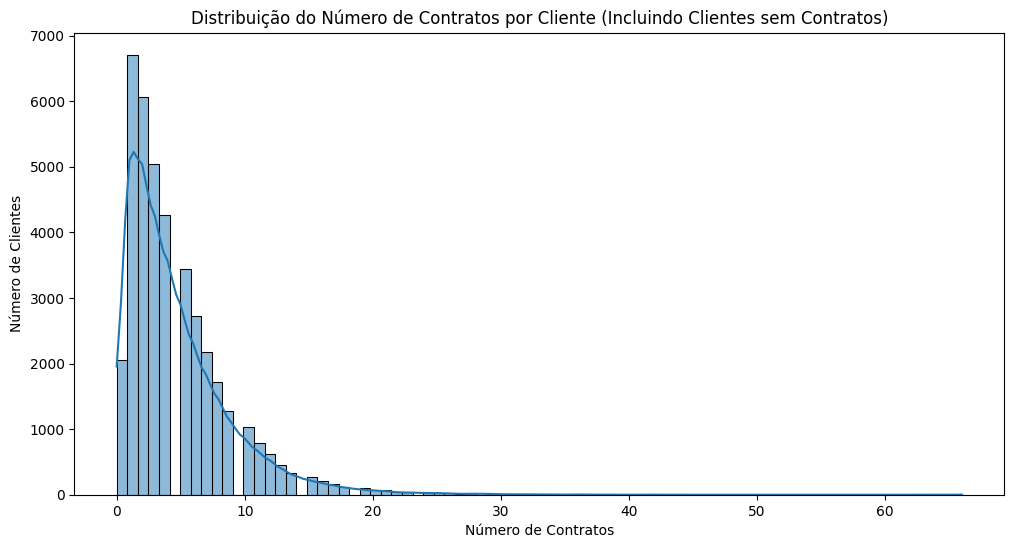

In [47]:
# Plotar a distribuição
plt.figure(figsize=(12, 6))
sns.histplot(contratos_por_cliente['num_contratos'], bins=80, kde=True)
plt.title('Distribuição do Número de Contratos por Cliente (Incluindo Clientes sem Contratos)')
plt.xlabel('Número de Contratos')
plt.ylabel('Número de Clientes')
plt.show()

In [48]:
df_parcelas['safra'] = df_parcelas['data_prevista_pagamento'].dt.to_period('M').astype(str)
df_emprestimos['safra'] = df_emprestimos['data_decisao'].dt.to_period('M').astype(str)

Gerando o gráfico de tendência...


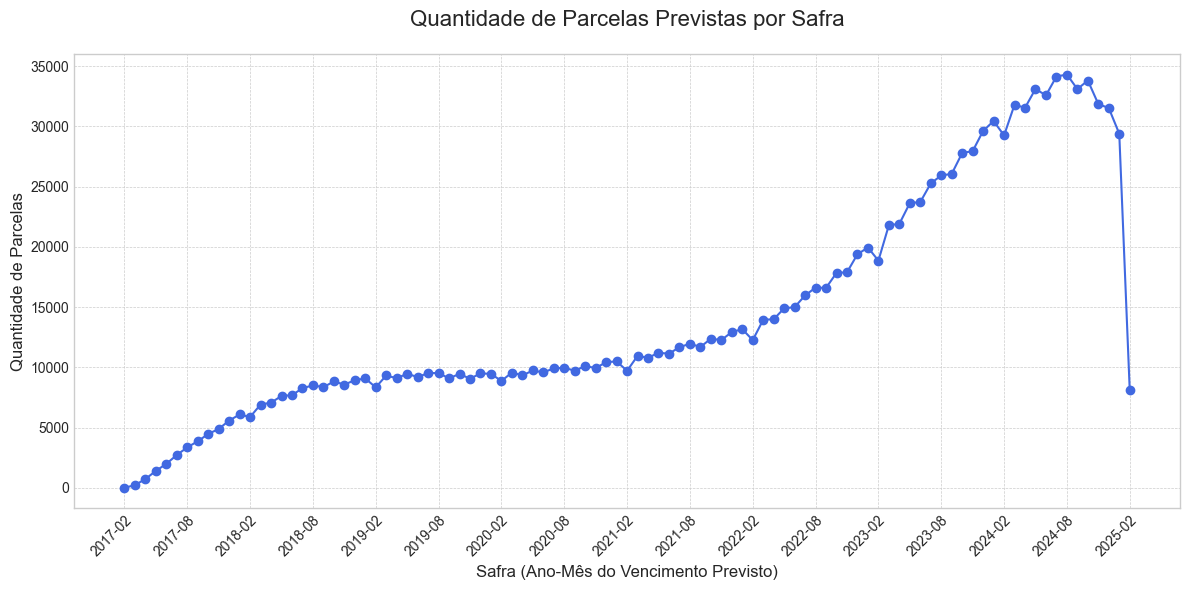

In [ ]:
# agrupar por safra e contar a quantidade de parcelas]
parcelas_por_safra = df_parcelas.groupby('safra').size().reset_index(name='quantidade_parcelas')
parcelas_por_safra = parcelas_por_safra.sort_values('safra')

# gerar o gráfico de linha
print("Gerando o gráfico de tendência...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(parcelas_por_safra['safra'], parcelas_por_safra['quantidade_parcelas'], marker='o', linestyle='-', color='royalblue')

# Melhorar a legibilidade do eixo X
tick_spacing = 6 # Mostra um label a cada 6 meses
ax.xaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adicionar títulos e labels
ax.set_title('Quantidade de Parcelas Previstas por Safra', fontsize=16, pad=20)
ax.set_xlabel('Safra (Ano-Mês do Vencimento Previsto)', fontsize=12)
ax.set_ylabel('Quantidade de Parcelas', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

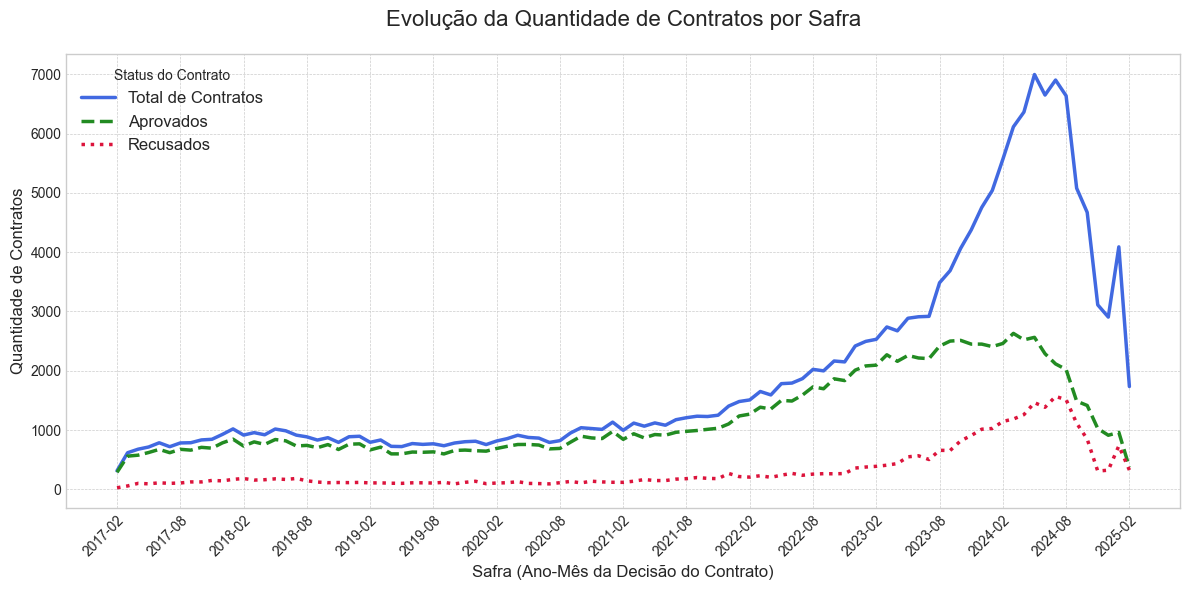

In [ ]:
# agrupar por safra e contar a quantidade de contratos
contratos_por_safra = df_emprestimos.groupby(['safra', 'status_contrato']).size().unstack(fill_value=0)
contratos_por_safra['total'] = contratos_por_safra.sum(axis=1)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

# Plotar a linha de Total de Contratos (mais grossa e sólida)
ax.plot(contratos_por_safra.index, contratos_por_safra['total'],
        label='Total de Contratos', color='royalblue', linestyle='-', linewidth=2.5)

ax.plot(contratos_por_safra.index, contratos_por_safra['Approved'],
        label='Aprovados', color='forestgreen', linestyle='--',  linewidth=2.5)

ax.plot(contratos_por_safra.index, contratos_por_safra['Refused'],
        label='Recusados', color='crimson', linestyle=':',  linewidth=2.5)

# Melhorar a legibilidade do eixo X
tick_spacing = 6 # Mostra um label a cada 6 meses
ax.xaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adicionar títulos, labels e a LEGENDA
ax.set_title('Evolução da Quantidade de Contratos por Safra', fontsize=16, pad=20)
ax.set_xlabel('Safra (Ano-Mês da Decisão do Contrato)', fontsize=12)
ax.set_ylabel('Quantidade de Contratos', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(title='Status do Contrato', fontsize='large') # Adiciona a legenda

plt.tight_layout()
plt.show()